# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [12]:
# Import essential libraries for data manipulation and analysis
# Data manipulation and numerical computing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time processing
from datetime import datetime

# Machine learning models and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure visualizations
sns.set(style="whitegrid")
plt.style.use('seaborn-poster')


OSError: 'seaborn-poster' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [15]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')

# Display the first few rows to verify
df.head()


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [20]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Verify the conversion
df[['created_at', 'actual_delivery_time']].dtypes



created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [23]:
# Convert categorical features to category type
# Convert appropriate columns to 'category' dtype
categorical_cols = ['store_primary_category', 'order_protocol', 'market_id']

for col in categorical_cols:
    df[col] = df[col].astype('category')

# Verify the conversion
df[categorical_cols].dtypes



store_primary_category    category
order_protocol            category
market_id                 category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [27]:
# Calculate time taken in minutes
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the new column
df[['created_at', 'actual_delivery_time', 'delivery_duration']].head()


,created_at,actual_delivery_time,delivery_duration
0,2015-02-06 22:24:17,2015-02-06 23:11:17,47.0
1,2015-02-10 21:49:25,2015-02-10 22:33:25,44.0
2,2015-02-16 00:11:35,2015-02-16 01:06:35,55.0
3,2015-02-12 03:36:46,2015-02-12 04:35:46,59.0
4,2015-01-27 02:12:36,2015-01-27 02:58:36,46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [30]:
# Extract hour and day of the week
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # Monday = 0, Sunday = 6

# Create a categorical feature 'isWeekend' (1 for weekend, 0 for weekday)
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Convert 'isWeekend' to category type
df['isWeekend'] = df['isWeekend'].astype('category')

# Preview the new features
df[['created_at', 'order_hour', 'order_dayofweek', 'isWeekend']].head()


,created_at,order_hour,order_dayofweek,isWeekend
0,2015-02-06 22:24:17,22,4,0
1,2015-02-10 21:49:25,21,1,0
2,2015-02-16 00:11:35,0,0,0
3,2015-02-12 03:36:46,3,3,0
4,2015-01-27 02:12:36,2,1,0


In [32]:
# Drop columns that are no longer needed
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

# Optionally print remaining columns to confirm
print(df.columns)

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'delivery_duration',
       'order_hour', 'order_dayofweek', 'isWeekend'],
      dtype='object')


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [36]:
# Define target variable
y = df['delivery_duration']

# Define features - exclude target and any identifiers (if present)
X = df.drop(columns=['delivery_duration'])

# Confirm the shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (175777, 15)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [39]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm the sizes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [43]:
# Define numerical columns (excluding target)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define categorical columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# Print the lists
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)



Numerical Columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical Columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

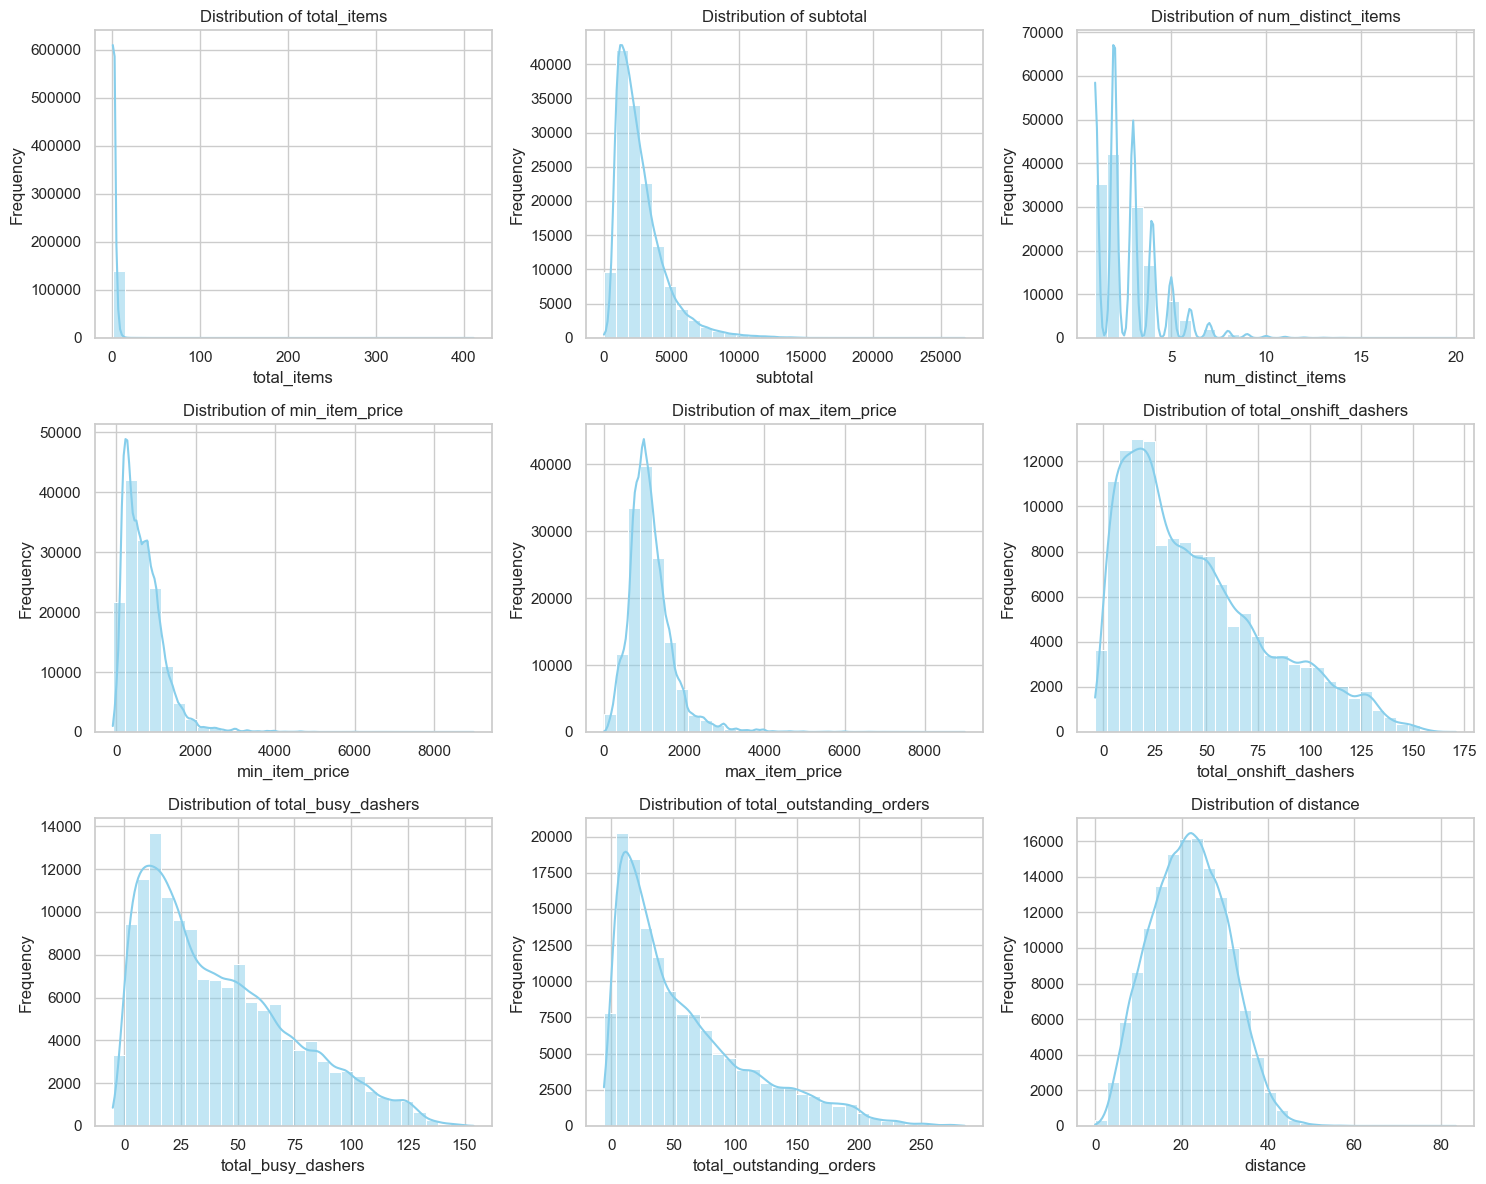

In [46]:
# Plot distributions for all numerical columns
# Import necessary library
import math

# Set up the plot grid
num_cols = len(numerical_cols)
cols = 3  # number of plots per row
rows = math.ceil(num_cols / cols)

plt.figure(figsize=(cols * 5, rows * 4))

# Plot each numerical feature
for i, col in enumerate(numerical_cols):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

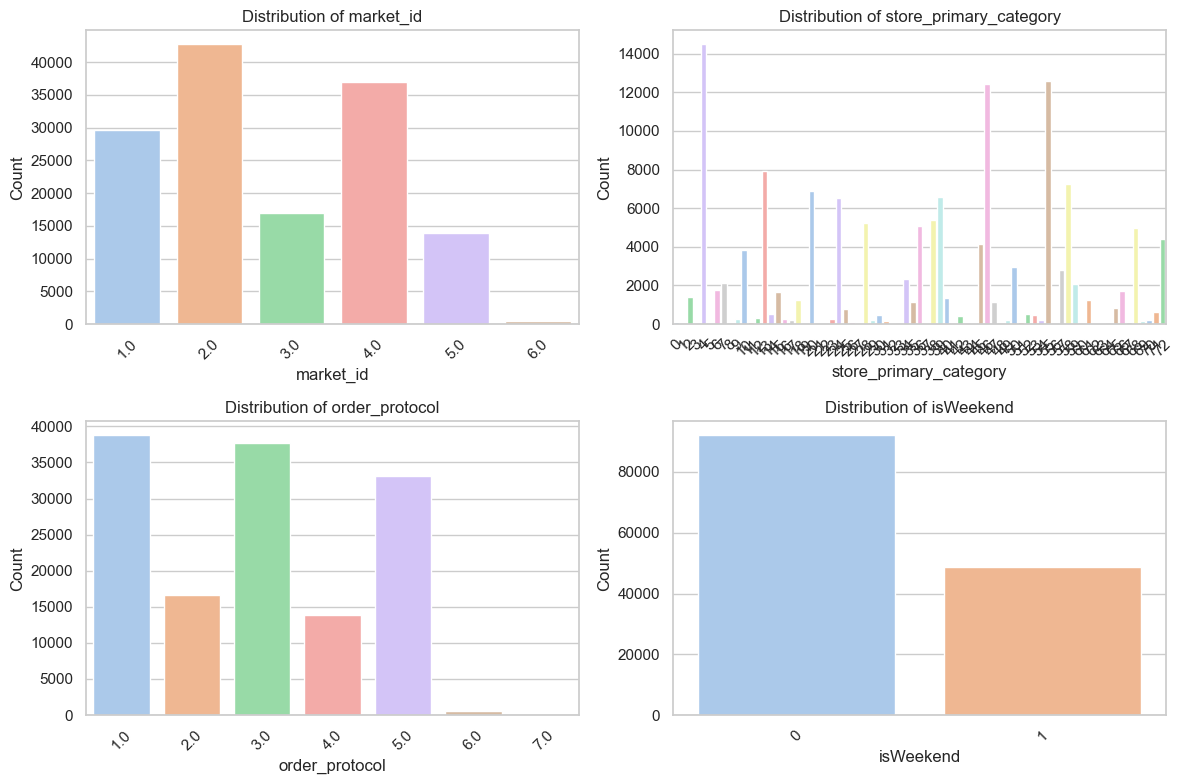

In [48]:
# Distribution of categorical columns
# Set up the plot grid
num_cats = len(categorical_cols)
cols = 2  # number of plots per row
rows = math.ceil(num_cats / cols)

plt.figure(figsize=(cols * 6, rows * 4))

# Plot each categorical feature
for i, col in enumerate(categorical_cols):
    plt.subplot(rows, cols, i + 1)
    sns.countplot(data=X_train, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

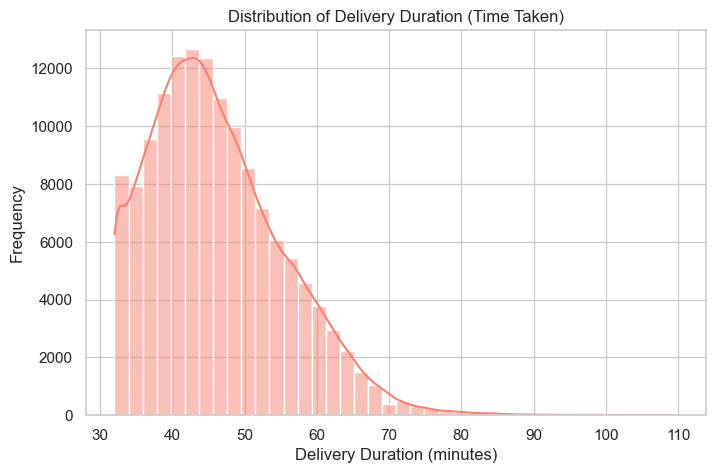

In [50]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=40, kde=True, color='salmon')
plt.title('Distribution of Delivery Duration (Time Taken)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

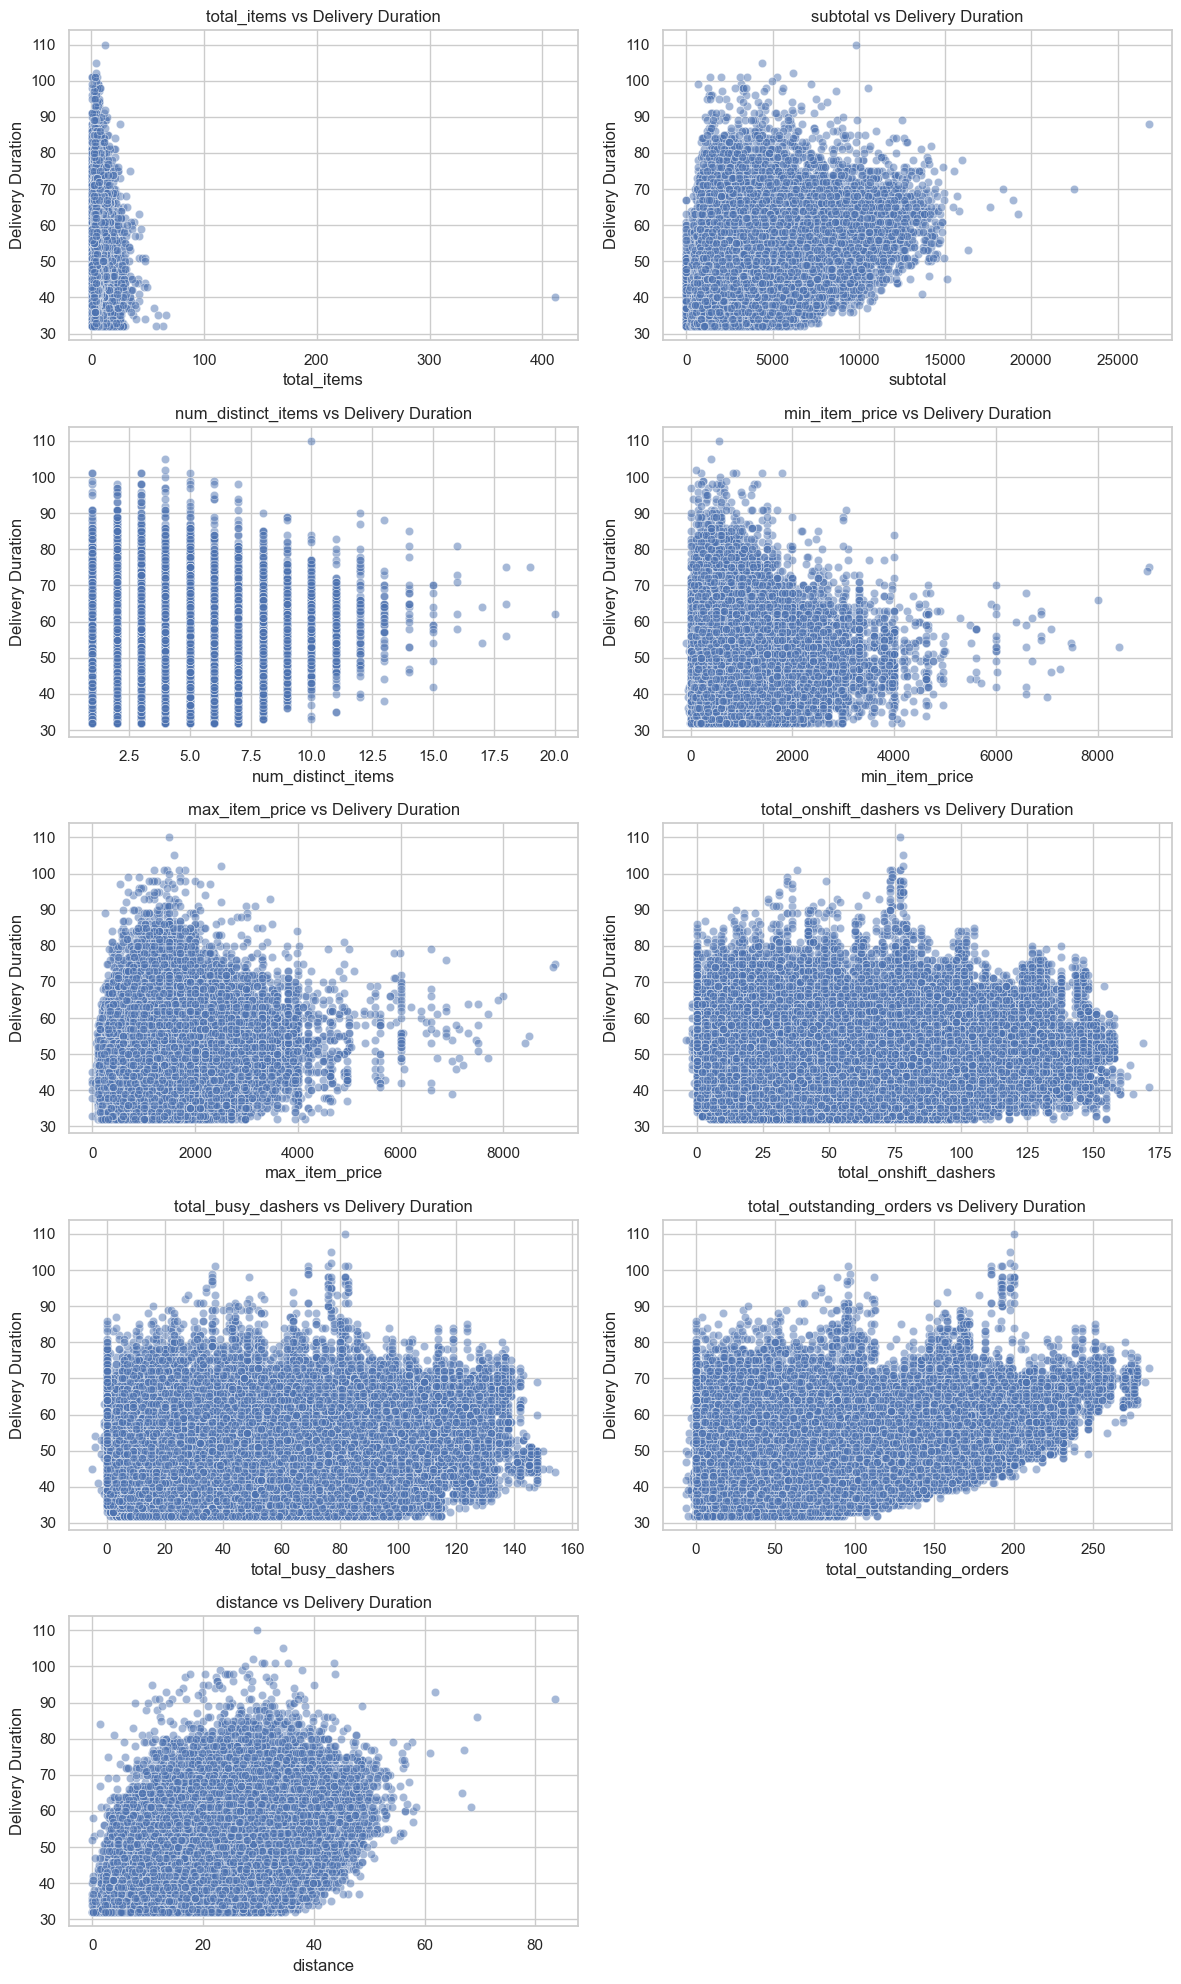

In [56]:
# Scatter plot to visualise the relationship between time_taken and other features
# Merge features and target for plotting
train_df = X_train.copy()
train_df['delivery_duration'] = y_train

# Set up plot grid
import math

num_cols = len(numerical_cols)
cols = 2
rows = math.ceil(num_cols / cols)

plt.figure(figsize=(cols * 6, rows * 4))

# Create scatter plots
for i, col in enumerate(numerical_cols):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(data=train_df, x=col, y='delivery_duration', alpha=0.5)
    plt.title(f'{col} vs Delivery Duration')
    plt.xlabel(col)
    plt.ylabel('Delivery Duration')

plt.tight_layout()
plt.show()



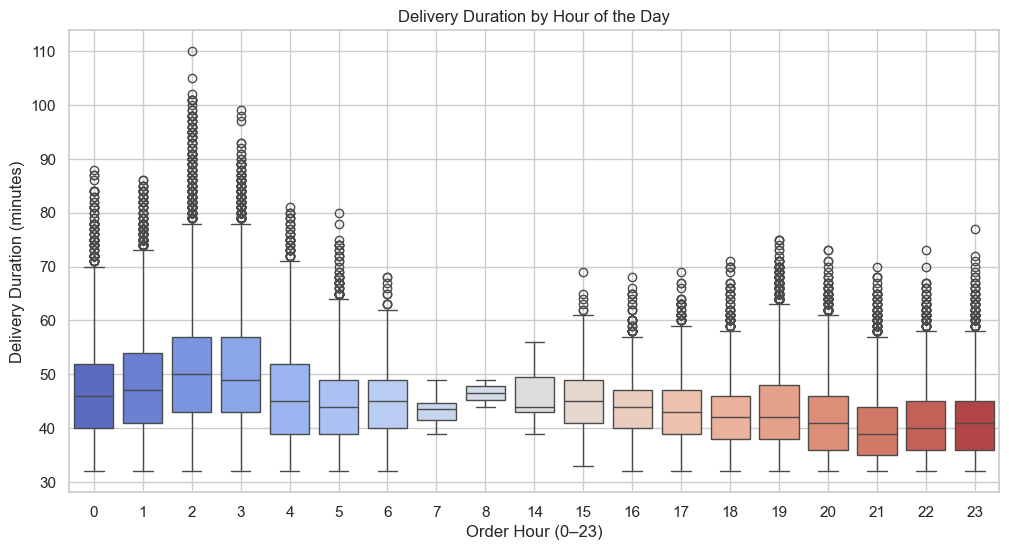

In [57]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='order_hour', y='delivery_duration', palette='coolwarm')
plt.title('Delivery Duration by Hour of the Day')
plt.xlabel('Order Hour (0–23)')
plt.ylabel('Delivery Duration (minutes)')
plt.grid(True)
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

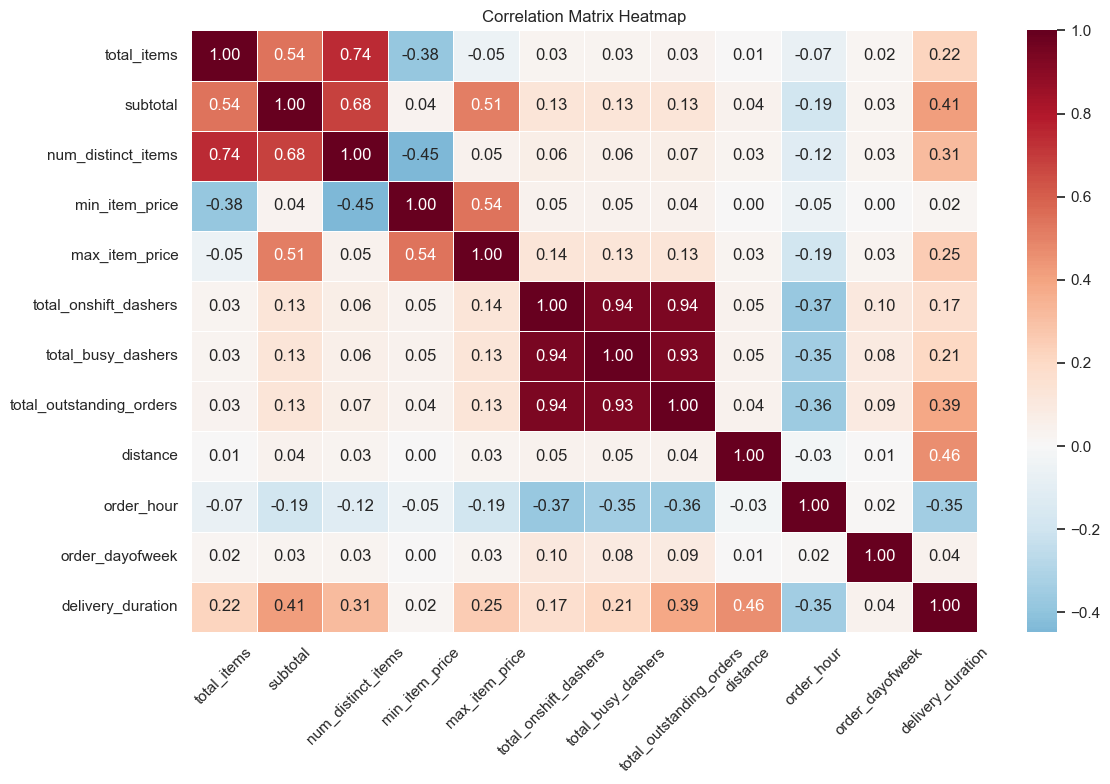

In [62]:
# Plot the heatmap of the correlation matrix
# Compute correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [65]:
# Drop 3-5 weakly correlated columns from training dataset

# Get correlation of features with the target variable
target_corr = train_df.corr(numeric_only=True)['delivery_duration'].drop('delivery_duration')

# Sort by absolute correlation values
weak_corr = target_corr.abs().sort_values()

# Display weakest correlations (change n if you want more)
print("Weakest correlated features:\n")
print(weak_corr.head(5))

# Drop selected weakly correlated columns
columns_to_drop = ['min_item_price', 'num_distinct_items', 'max_item_price']  # Example: use actual low-correlation columns from above
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)



Weakest correlated features:

min_item_price           0.021151
order_dayofweek          0.044897
total_onshift_dashers    0.171828
total_busy_dashers       0.206514
total_items              0.220804
Name: delivery_duration, dtype: float64


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

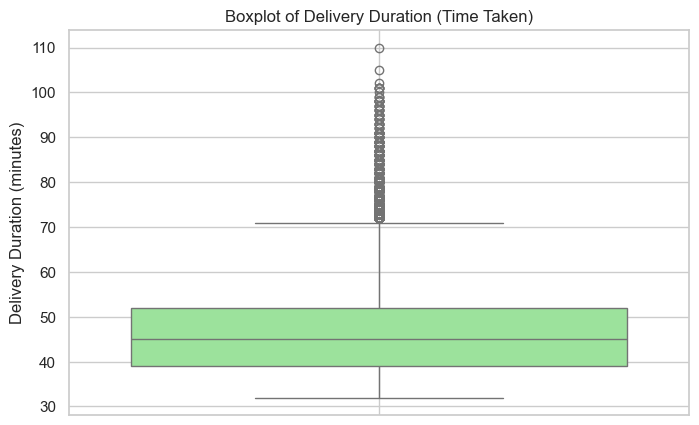

In [69]:
# Boxplot for time_taken
plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train, color='lightgreen')
plt.title('Boxplot of Delivery Duration (Time Taken)')
plt.ylabel('Delivery Duration (minutes)')
plt.grid(True)
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

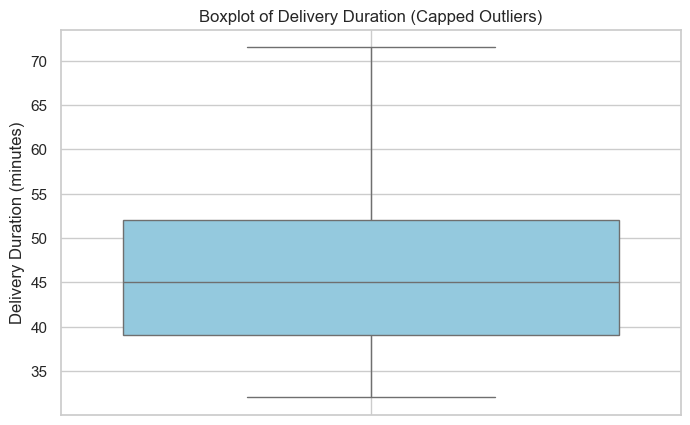

In [72]:
# Handle outliers
# Copy the target variable to preserve original
y_train_capped = y_train.copy()

# Calculate IQR
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the values
y_train_capped = y_train_capped.clip(lower=lower_bound, upper=upper_bound)

# Optional: Visualize after capping
plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train_capped, color='skyblue')
plt.title('Boxplot of Delivery Duration (Capped Outliers)')
plt.ylabel('Delivery Duration (minutes)')
plt.grid(True)
plt.show()





## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [75]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [79]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [82]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [85]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [88]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [91]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [95]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [98]:
# Apply scaling to the numerical columns

# Redefine numerical and categorical columns (if not already defined)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline with scaling and encoding
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])



Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [103]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()


In [105]:
# Train the model using the training data

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),     # includes scaling + encoding
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['total_items', 'subtotal',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['market_id',
                                                   'store_primary_category',
                                                   'order_protocol',
                                                   'isWeekend'])])),
                ('regressor', LinearRegression())])

In [107]:
# Make predictions
# Predict on the test set
y_test_pred = model.predict(X_test)


y_train_pred = model.predict(X_train)

In [109]:
# Find results for evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate on Test Set
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Print metrics
print("Model Evaluation Metrics (Test Set):")
print(f"MAE : {mae:.2f} minutes")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")




Model Evaluation Metrics (Test Set):
MAE : 2.52 minutes
MSE : 11.60
RMSE: 3.41 minutes
R² Score: 0.87


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Apply preprocessing manually
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Initialize linear regression model
lr = LinearRegression()

# Initialize RFE (you can change n_features_to_select)
rfe = RFE(estimator=lr, n_features_to_select=5)

# Fit RFE
rfe.fit(X_train_processed, y_train)

# Predict with reduced features
y_pred_rfe = rfe.predict(X_test_processed)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("RFE Model Performance:")
print(f"MAE : {mean_absolute_error(y_test, y_pred_rfe):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rfe)):.2f}")
print(f"R²  : {r2_score(y_test, y_pred_rfe):.2f}")

from sklearn.model_selection import cross_val_score

for k in range(3, X_train_processed.shape[1] + 1, 2):
    rfe = RFE(estimator=lr, n_features_to_select=k)
    rfe.fit(X_train_processed, y_train)
    scores = cross_val_score(rfe, X_train_processed, y_train, cv=5, scoring='r2')
    print(f"{k} features - R² (CV): {scores.mean():.3f}")


RFE Model Performance:
MAE : 3.86
RMSE: 4.96
R²  : 0.72


In [ ]:
# Build the final model with selected number of features

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you have:
# X_train_processed, X_test_processed (after preprocessing)
# y_train, y_test (target variables)
# numerical_cols and categorical_cols defined
# preprocessor = your ColumnTransformer or Pipeline including encoding for categorical columns

# Initialize Linear Regression model
lr_final = LinearRegression()

# Number of features to select
k = 8

# Fit RFE with the model and select top k features
rfe_final = RFE(estimator=lr_final, n_features_to_select=k)
rfe_final.fit(X_train_processed, y_train)

# Get indices of selected features
selected_indices = rfe_final.get_support(indices=True)

# Get feature names after preprocessing:
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(encoded_cols)

# Selected feature names
selected_features = [all_feature_names[i] for i in selected_indices]
print(f"Selected Top {k} Features:\n", selected_features)

# Predict on test data using RFE-selected features
y_pred_final = rfe_final.predict(X_test_processed)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)

print("\nFinal Model Performance:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")



## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
matplotlib.pyplot as plt
scipy.stats

residuals = y_test - y_pred_final

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_final, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Delivery Time")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model

# Get means and stds from the fitted StandardScaler
scaler = preprocessor.named_transformers_['num']
feature_means = scaler.mean_
feature_stds = scaler.scale_

# Full list of original feature names
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(encoded_cat_features)

# Get indices of selected features from RFE
selected_indices = rfe_final.get_support(indices=True)
selected_features = [all_features[i] for i in selected_indices]

# Get coefficients from model
scaled_coefs = rfe_final.estimator_.coef_

# Create DataFrame for comparison
comparison = pd.DataFrame({
    'Feature': selected_features,
    'Scaled_Coefficient': scaled_coefs
})

# Add unscaled coefficient for numerical features only
unscaled_values = []
for feat in selected_features:
    if feat in numerical_cols:
        idx = numerical_cols.index(feat)
        unscaled_coef = scaled_coefs[comparison[comparison['Feature'] == feat].index[0]] / feature_stds[idx]
        unscaled_values.append(unscaled_coef)
    else:
        # Categorical features remain same because OneHot is not scaled
        unscaled_values.append(scaled_coefs[comparison[comparison['Feature'] == feat].index[0]])

comparison['Unscaled_Coefficient'] = unscaled_values

# Sort by absolute impact of unscaled coefficients
comparison_sorted = comparison.reindex(comparison.Unscaled_Coefficient.abs().sort_values(ascending=False).index)
print(comparison_sorted)



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'

coef_total_items = comparison.loc[comparison['Feature'] == 'total_items', 'Unscaled_Coefficient'].values[0]
print(f"Unscaled Coefficient for 'total_items': {coef_total_items:.2f}")





Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are categorical variables in the dataset. store_primary_category, order_protocol, market_id, isWeekend.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>The parameter `test_size = 0.2` means that 20% of the dataset is used for testing the model, while the remaining 80% is used for training. This helps evaluate how well the model performs on unseen data.




---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the heatmap, **`distance`** has the highest correlation with the target variable `time_taken`, indicating that longer distances lead to higher delivery times.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>I detected outliers by visualizing the delivery time (time_taken) using boxplots and calculating the Interquartile Range (IQR). Points lying beyond 1.5 times the IQR from the first and third quartiles were considered outliers. To address them, I removed these extreme values from the dataset to prevent them from skewing the model and to improve overall prediction accuracy.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on the final model, the top 3 features significantly affecting the delivery time are:
Distance – The most influential feature; as distance increases, delivery time also increases significantly.
Total Busy Dashers – A higher number of busy delivery partners at the time of order placement tends to increase delivery time.
Order Protocol – The way the order is placed (e.g., via app, phone, etc.) impacts how quickly it is processed and delivered.
These features had the highest coefficients and/or strongest correlation with the target variable time_taken in the final regression model.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression is a supervised machine learning algorithm used to predict a continuous outcome (target variable) based on one or more input features. It establishes a linear relationship between the dependent and independent variables, meaning it tries to fit a straight line (or plane in higher dimensions) through the data.
>
>The algorithm assumes the relationship between the input variables (features) and the target variable can be represented with a linear equation:
>
>The algorithm finds the best-fitting line by minimizing the difference between the actual values and predicted values using a cost function, typically Mean Squared Error (MSE).




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression uses one independent variable to predict the dependent variable, while multiple linear regression uses two or more independent variables to make predictions.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function (usually Mean Squared Error) measures the difference between actual and predicted values. It is minimized using optimization algorithms like Gradient Descent to improve model accuracy.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting occurs when the model learns the training data too well, including noise, and performs poorly on new data.
Underfitting happens when the model is too simple and fails to capture the patterns in the data.




---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the difference between actual and predicted values. A random scatter suggests a good model fit, while patterns (like curves or funnels) indicate issues like non-linearity or heteroscedasticity.
